In [1]:
using SchwarzChristoffel

In [2]:
p = Polygon([-1.0,0.2,1.0,-1.0],[-1.0,-1.0,0.5,1.0])

Polygon with 4 vertices at
             (-1.0,-1.0) (0.2,-1.0) (1.0,0.5) (-1.0,1.0) 
             interior angles/π = [0.5, 0.656, 0.422, 0.422]


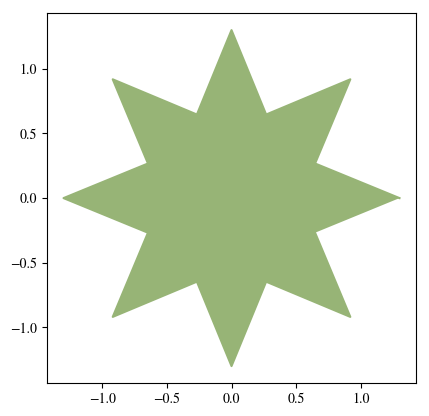

In [31]:
n = 8; dθ = 2π/(2n)
θ = collect(0:dθ:2π-dθ)
w = (1+0.3cos.(n*θ)).*exp.(im*θ)
p = Polygon(w)
plot(p)

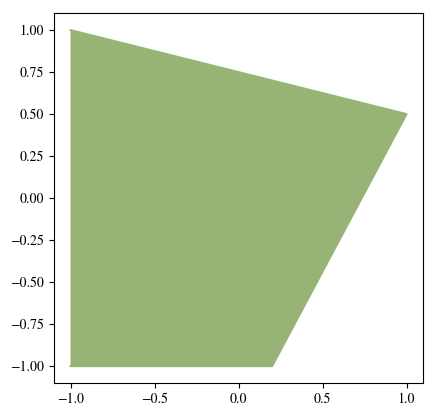

In [7]:
plot(p)

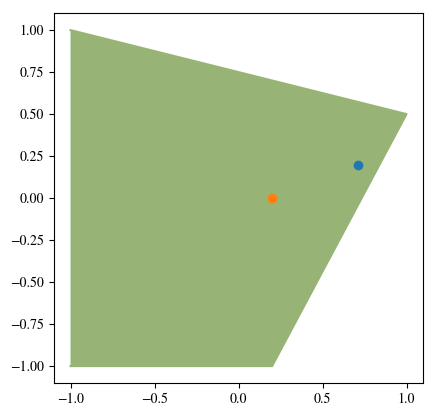

1×2 BitArray{2}:
 true  true

In [6]:
z = [0.71+im*0.2 0.2+im*0]
plot(p)
PyPlot.plot(real.(z),imag.(z),marker="o")
isinpoly.(z,p,1e-5)

In [32]:
m = ExteriorMap(p)

Exterior map with
   vertices: (1.3,0.0), (0.6467,0.2679), (0.9192,0.9192), (0.2679,0.6467), (0.0,1.3), (-0.2679,0.6467), (-0.9192,0.9192), (-0.6467,0.2679), (-1.3,0.0), (-0.6467,-0.2679), (-0.9192,-0.9192), (-0.2679,-0.6467), (-0.0,-1.3), (0.2679,-0.6467), (0.9192,-0.9192), (0.6467,-0.2679), 
   interior angles/π: 0.2477, 1.5023, 0.2477, 1.5023, 0.2477, 1.5023, 0.2477, 1.5023, 0.2477, 1.5023, 0.2477, 1.5023, 0.2477, 1.5023, 0.2477, 1.5023, 
   prevertices on circle: (1.0,0.0), (0.9239,-0.3827), (0.7071,-0.7071), (0.3827,-0.9239), (-0.0,-1.0), (-0.3827,-0.9239), (-0.7071,-0.7071), (-0.9239,-0.3827), (-1.0,0.0), (-0.9239,0.3827), (-0.7071,0.7071), (-0.3827,0.9239), (0.0,1.0), (0.3827,0.9239), (0.7071,0.7071), (0.9239,0.3827), 
   prevertex angles/π: 0.0, 0.125, 0.25, 0.375, 0.5, 0.625, 0.75, 0.875, -1.0, -0.875, -0.75, -0.625, -0.5, -0.375, -0.25, -0.125, 
   constant = -1.1279 - 0.0im, accuracy = 1.0e-8, 
   number of multipole coefficients = 12


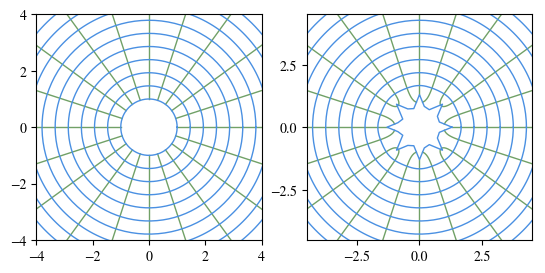

In [33]:
conformal_grid(m)

In [11]:
m = ExteriorMap(p;tol=1e-12)

Exterior map with
   vertices: (-1.0,-1.0), (0.2,-1.0), (1.0,0.5), (-1.0,1.0), 
   interior angles/π: 0.5, 0.656, 0.422, 0.422, 
   prevertices on circle: (1.0,0.0), (0.3764,-0.9265), (-0.9024,-0.4309), (-0.1868,0.9824), 
   constant = 0.6722 + 0.7669im, accuracy = 1.0e-12, 
   number of multipole coefficients = 12


In [9]:
prev, C = parameters(m)

(Complex{Float64}[1.0+0.0im, 0.376406-0.926455im, -0.902383-0.430935im, -0.186756+0.982406im], 0.6722109863402015 + 0.7668866078562682im)

In [5]:
ccoeff, dcoeff = coefficients(m);

In [6]:
ccoeff

14-element Array{Complex{Float64},1}:
       1.0198+0.0im        
    -0.210364-0.0161983im  
  -0.00655708+0.0398156im  
     0.136922+0.0951343im  
    -0.095035+0.0891769im  
    0.0184341+0.0299586im  
    0.0136513+2.78095e-5im 
   -0.0159533-0.00264418im 
  -0.00167426-0.00501161im 
  -0.00578705-0.000221652im
  -0.00447511+0.00252069im 
   0.00469089-0.00150588im 
  0.000441767-0.00192516im 
 -0.000381357-0.00174291im 

In [5]:
zeta = [0.1,0.5-0.75im,-0.25-0.3im]
dz, ddz = evalderiv(zeta,m,true);
dz

3-element Array{Complex{Float64},1}:
  67.2068+76.6284im 
 -1.11666+0.544576im
  3.99129-5.30641im 

In [6]:
zeta = [1.0+3.0im,-2.0-2.0im,0.0+1.1im]
z = evaluate(zeta,m)

3-element Array{Complex{Float64},1}:
   0.81614+3.02956im 
  -2.25237-2.08523im 
 -0.333104+0.975837im

In [16]:
zeta = collect(1.1:0.1:2.0) + 0.1im
dz,ddz = evalderiv(zeta,m)
dz

10-element Array{Complex{Float64},1}:
 0.872356-0.394475im 
 0.901724-0.289355im 
 0.925562-0.217994im 
 0.944059-0.168264im 
 0.958255-0.132657im 
  0.96919-0.106522im 
 0.977695-0.0869128im
 0.984389-0.0719115im
 0.989723-0.0602376im
 0.994025-0.0510144im

In [11]:
z = evaluate(zeta,m)

3-element Array{Complex{Float64},1}:
   0.81614+3.02956im 
  -2.25237-2.08523im 
 -0.333104+0.975837im

In [7]:
mean([sum(ccoeff.*zeta[i].^(1:-1:-m.ncoeff))-z[i] for i = 1:length(zeta)])

2.5518320641274943e-5 + 8.985895672545634e-5im